In [1]:
import pandas as pd
import rasterio
from rasterstats import zonal_stats
from osgeo import gdal
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyproj import CRS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pyproj
#load all the required libraries
import netCDF4 as nc
import glob
import pickle 
import random
from tqdm import tqdm  
import datetime as datetime
import gc
import os
import h5py
from scipy.stats import pearson3, norm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
outage = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Copy of POUS_export_citybyutility_hourly_nj_ny_Aug_2020/POUS_export_citybyutility_hourly_nj_ny_Aug_2020.csv")
outage.head()

,UtilityName,StateName,CountyName,CountyFIPS,CityName,CustomersTracked,CustomersOut,RecordDateTime
0,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 00:00:00
1,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 01:00:00
2,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 02:00:00
3,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 03:00:00
4,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 04:00:00


In [3]:
outage_nj = outage[outage["StateName"] == "New Jersey"]
outage_nj.head()

,UtilityName,StateName,CountyName,CountyFIPS,CityName,CustomersTracked,CustomersOut,RecordDateTime
0,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 00:00:00
1,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 01:00:00
2,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 02:00:00
3,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 03:00:00
4,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 04:00:00


In [4]:
#get percentage of customers without power between 9 and 10 pm
# Convert RecordDateTime column to datetime
outage_nj['RecordDateTime'] = pd.to_datetime(outage_nj['RecordDateTime'])

# Filter the dataframe to include only rows between 9 and 10 PM
filtered_df = outage_nj[(outage_nj['RecordDateTime'].dt.hour >= 21) & (outage_nj['RecordDateTime'].dt.hour < 22)]

# Calculate the percentage of customers without power
filtered_df["percentage_without_power"] = (filtered_df['CustomersOut'] / filtered_df['CustomersTracked']) * 100

filtered_df.head()

C:\Users\omhai\AppData\Local\Temp\ipykernel_16724\188801650.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outage_nj['RecordDateTime'] = pd.to_datetime(outage_nj['RecordDateTime'])
C:\Users\omhai\AppData\Local\Temp\ipykernel_16724\188801650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["percentage_without_power"] = (filtered_df['CustomersOut'] / filtered_df['CustomersTracked']) * 100


,UtilityName,StateName,CountyName,CountyFIPS,CityName,CustomersTracked,CustomersOut,RecordDateTime,percentage_without_power
21,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-01 21:00:00,0.000000
45,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4440,0,2020-08-02 21:00:00,0.000000
69,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4437,0,2020-08-03 21:00:00,0.000000
93,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4437,3137,2020-08-04 21:00:00,70.700924
117,Atlantic City Electric,New Jersey,Atlantic,34001.0,Absecon City,4437,329,2020-08-05 21:00:00,7.414920


In [5]:
filtered_df["CountyName"].unique()

array(['Atlantic', 'Burlington', 'Camden', 'Cape May', 'Cumberland',
       'Gloucester', 'Ocean', 'Salem', 'Essex', 'Hunterdon', 'Mercer',
       'Middlesex', 'Monmouth', 'Morris', 'Passaic', 'Somerset', 'Sussex',
       'Union', 'Warren', 'Bergen', 'Hudson'], dtype=object)

In [7]:
outage_nj["CountyFIPS"].nunique()

21

In [8]:
# Extract the date from the datetime column
filtered_df['Date'] = filtered_df['RecordDateTime'].dt.date

# Pivot the dataframe
pivot_df = filtered_df.pivot_table(index='CountyName', columns='Date', values='percentage_without_power')
pivot_df

C:\Users\omhai\AppData\Local\Temp\ipykernel_16724\154476396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = filtered_df['RecordDateTime'].dt.date


Date,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31
CountyName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Atlantic,0.000000,0.000000,0.000000,43.620050,20.427506,9.077938,2.266028,0.667812,0.080769,0.015103,0.017359,0.005352,0.021756,0.008501,0.001083,0.004901,0.002384,0.010103,0.000850,0.096549,0.000354,0.000000,0.000000,0.019820,0.000000,0.003211,0.000000,0.000000,0.000000,0.107716,0.000454
Bergen,0.000299,0.000678,0.001867,44.122870,35.027872,19.286492,17.384829,5.855543,1.185458,0.393406,0.141189,0.457679,0.052590,0.014006,0.011136,0.023571,0.207717,0.011127,0.012514,0.010190,0.009796,0.026189,0.001611,0.012459,0.025426,0.064980,0.008378,0.008129,0.043419,0.003127,0.005742
Burlington,0.000876,0.067543,0.060011,50.455926,24.871612,14.077438,6.921632,2.759677,0.126463,1.589330,0.017974,0.226160,0.005044,0.017153,0.013206,0.002344,0.002816,0.003859,0.000000,0.000813,0.011048,0.014244,0.002095,0.008548,0.002848,0.006916,0.003395,0.004461,0.002841,0.015924,0.005079
Camden,0.002054,0.048477,0.000000,7.673421,2.604477,2.199511,0.322825,0.119978,0.037005,0.026997,0.002059,1.974848,0.138392,0.001328,0.000631,0.128882,0.000747,0.000000,0.049113,0.000336,0.004912,0.000336,0.000000,0.002072,0.000174,0.000000,0.000336,0.013101,0.018057,0.000000,0.003067
Cape May,0.009843,0.000000,0.000000,31.331484,19.111048,5.149395,0.929233,0.136452,0.018203,0.020943,0.012942,0.006848,0.011621,0.003358,0.004331,0.001439,0.033379,0.006848,0.000000,0.000897,0.000857,0.000000,0.000000,0.000000,0.001020,0.001495,0.000815,0.000000,0.010911,0.000000,0.000000
Cumberland,0.000000,0.000000,0.013167,78.852586,12.601063,5.744498,1.388089,0.713831,0.027615,0.154913,0.040777,0.026130,0.191607,0.000000,0.000000,0.010424,0.025247,0.008046,0.000000,0.000000,0.000000,0.000000,0.000000,0.006790,0.034142,0.007384,0.030661,0.000000,0.005120,0.000000,0.000000
Essex,0.016875,0.001117,0.039975,32.855342,19.881227,12.105627,9.410001,5.176849,1.328312,0.257833,0.189868,0.024751,0.012327,0.013551,0.024458,0.157617,0.002152,0.014010,0.014541,0.446934,0.013696,0.089261,0.696315,0.009593,0.117615,0.024059,0.010642,0.002036,0.005141,0.010207,0.002193
Gloucester,0.000000,0.002988,0.002943,15.306175,2.640894,0.723230,0.243739,0.591735,0.086513,0.037813,0.001745,0.411234,0.014940,0.011095,0.002941,0.005526,0.002854,0.001444,0.000000,0.000791,0.001520,0.000000,0.000000,0.002114,0.001381,0.000000,0.002378,0.000000,0.000000,0.000000,0.011456
Hudson,0.001035,0.001263,0.000228,9.758123,3.453246,0.966889,0.445439,0.794885,0.025289,0.016517,0.011598,0.001829,0.020285,0.012994,0.001379,0.001035,0.013957,0.002522,0.001035,0.001263,0.000228,0.004370,0.001379,0.001379,0.006136,0.012648,0.029675,0.000228,0.001005,0.000000,0.000228


- Morris recovered the slowest (do we see similar patterns in Nightlights?)
- Does percentage change and recovery time as seen with nightlights reflect the ground situation?

### Rainfall

In [9]:
#load the new data

files_list = sorted(glob.glob('C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Rainfall/Isaias/Rainfall/*.nc4'))

In [10]:
# Open the .nc4 file
file_path = files_list[0]
dataset = nc.Dataset(file_path)

dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.8 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    BeginDate: 2020-08-01
    BeginTime: 00:00:00.000Z
    EndDate: 2020-08-01
    EndTime: 23:59:59.999Z
    FileHeader: StartGranuleDateTime=2020-08-01T00:00:00.000Z;
StopGranuleDateTime=2020-08-01T23:59:59.999Z
    InputPointer: 3B-HHR.MS.MRG.3IMERG.20200801-S000000-E002959.0000.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S003000-E005959.0030.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S010000-E012959.0060.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S013000-E015959.0090.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S020000-E022959.0120.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S023000-E025959.0150.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S030000-E032959.0180.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S033000-E035959.0210.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S040000-E042959.0240.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S0430

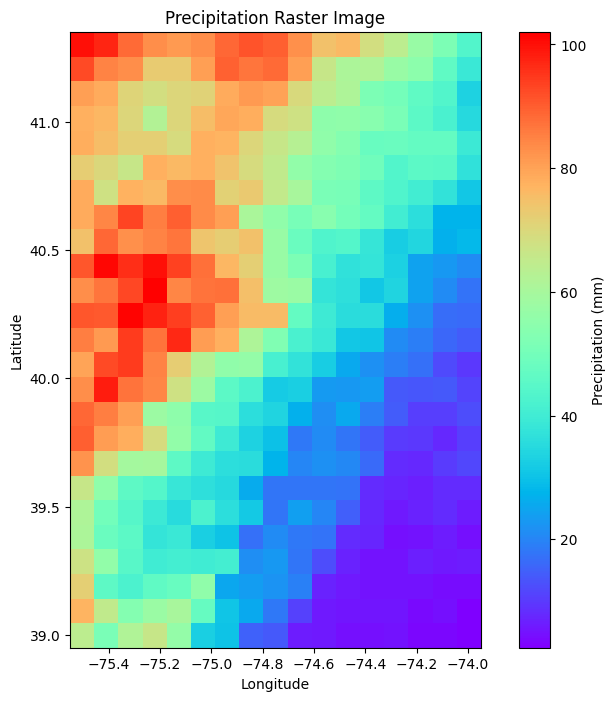

In [11]:
dataset = nc.Dataset(files_list[3])

# Read the variable
precipitation = dataset.variables['precipitationCal'][:]

# Get the longitude and latitude values
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

# Create a grid of longitude and latitude values
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Plot the raster image
plt.figure(figsize=(10, 8))
plt.imshow(precipitation[0].T, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='rainbow')
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation Raster Image')
plt.show()

In [12]:
county = gpd.read_file("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Zipcode_Analysis/county_nj.shp")
county.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,34,037,00882236,34037,Sussex,Sussex County,06,H1,G4020,408,35620,35084,A,1343330731,43707483,+41.1374609,-074.6919141,"POLYGON ((-74.48244 41.10358, -74.48263 41.103..."
1,34,007,00882273,34007,Camden,Camden County,06,H1,G4020,428,37980,15804,A,573325497,15688953,+39.8024071,-074.9612493,"POLYGON ((-74.90237 39.79104, -74.90207 39.790..."
2,34,039,00882235,34039,Union,Union County,06,H1,G4020,408,35620,35084,A,266163567,6847407,+40.6598707,-074.3086957,"POLYGON ((-74.20067 40.63290, -74.20240 40.631..."
3,34,009,00882274,34009,Cape May,Cape May County,06,H1,G4020,428,36140,None,A,651437935,955149083,+39.0858411,-074.8463541,"POLYGON ((-74.54044 39.29945, -74.54012 39.299..."
4,34,005,00882272,34005,Burlington,Burlington County,06,H1,G4020,428,37980,15804,A,2070137466,54133685,+39.8757858,-074.6630063,"POLYGON ((-74.47024 39.92253, -74.47010 39.922..."


In [13]:
# Calculate the center latitude and longitude for each county
county['CenterLat'] = county.geometry.centroid.y
county['CenterLon'] = county.geometry.centroid.x

county.head()

C:\Users\omhai\AppData\Local\Temp\ipykernel_16724\4097122183.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county['CenterLat'] = county.geometry.centroid.y
C:\Users\omhai\AppData\Local\Temp\ipykernel_16724\4097122183.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county['CenterLon'] = county.geometry.centroid.x


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,CenterLat,CenterLon
0,34,037,00882236,34037,Sussex,Sussex County,06,H1,G4020,408,35620,35084,A,1343330731,43707483,+41.1374609,-074.6919141,"POLYGON ((-74.48244 41.10358, -74.48263 41.103...",41.139307,-74.690839
1,34,007,00882273,34007,Camden,Camden County,06,H1,G4020,428,37980,15804,A,573325497,15688953,+39.8024071,-074.9612493,"POLYGON ((-74.90237 39.79104, -74.90207 39.790...",39.803539,-74.959754
2,34,039,00882235,34039,Union,Union County,06,H1,G4020,408,35620,35084,A,266163567,6847407,+40.6598707,-074.3086957,"POLYGON ((-74.20067 40.63290, -74.20240 40.631...",40.659931,-74.308222
3,34,009,00882274,34009,Cape May,Cape May County,06,H1,G4020,428,36140,None,A,651437935,955149083,+39.0858411,-074.8463541,"POLYGON ((-74.54044 39.29945, -74.54012 39.299...",39.085098,-74.849977
4,34,005,00882272,34005,Burlington,Burlington County,06,H1,G4020,428,37980,15804,A,2070137466,54133685,+39.8757858,-074.6630063,"POLYGON ((-74.47024 39.92253, -74.47010 39.922...",39.877717,-74.668067


In [14]:
county = county[["NAME","CenterLat","CenterLon"]]
county

,NAME,CenterLat,CenterLon
0,Sussex,41.139307,-74.690839
1,Camden,39.803539,-74.959754
2,Union,40.659931,-74.308222
3,Cape May,39.085098,-74.849977
4,Burlington,39.877717,-74.668067
5,Middlesex,40.440064,-74.408860
6,Hudson,40.730754,-74.076178
7,Monmouth,40.286159,-74.159361
8,Somerset,40.563507,-74.616337
9,Ocean,39.865932,-74.249916


In [16]:
import netCDF4 as nc
import numpy as np
from scipy.spatial import cKDTree
import pandas as pd

# Open the netCDF file
dataset = nc.Dataset(files_list[3])

# Read the variable
precipitation = dataset.variables['precipitationCal'][:]

# Get the longitude and latitude values
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

# Reshape the longitude and latitude arrays to have the same dimensions
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Create a KDTree from the reshaped longitude and latitude arrays
tree = cKDTree(np.column_stack((lon_2d.ravel(), lat_2d.ravel())))

# Read the county dataframe with CenterLat and CenterLon columns
county_df = county.copy()  # Replace "path_to_county_dataframe.csv" with the actual file path

# Find the nearest grid points to the county coordinates
distances, indices = tree.query(np.column_stack((county_df['CenterLon'], county_df['CenterLat'])))

# Get the rainfall values for the nearest grid points
rainfall_values = precipitation.ravel()[indices]

# Add the rainfall values to the county dataframe
county_df['Rainfall'] = rainfall_values

# Print the updated county dataframe
print(county_df)


          NAME  CenterLat  CenterLon    Rainfall
0       Sussex  41.139307 -74.690839    7.626932
1       Camden  39.803539 -74.959754   44.400085
2        Union  40.659931 -74.308222    5.259776
3     Cape May  39.085098 -74.849977  100.068230
4   Burlington  39.877717 -74.668067   77.742920
5    Middlesex  40.440064 -74.408860   42.949879
6       Hudson  40.730754 -74.076178   53.888355
7     Monmouth  40.286159 -74.159361   32.596832
8     Somerset  40.563507 -74.616337   17.449230
9        Ocean  39.865932 -74.249916   72.112228
10  Gloucester  39.717265 -75.141413   87.527588
11  Cumberland  39.328099 -75.129318   70.850410
12      Morris  40.862004 -74.544511   10.203543
13       Essex  40.787215 -74.247060   49.469360
14      Bergen  40.959689 -74.074207    6.910909
15      Warren  40.857149 -74.997350    4.585941
16     Passaic  41.034306 -74.300776   45.583881
17       Salem  39.576775 -75.357986   38.996212
18   Hunterdon  40.567297 -74.912248    6.816717
19    Atlantic  39.4

In [17]:
landcover_zonal = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/landcover_county_NJ.csv")
histo_columns = ['HISTO_0', 'HISTO_1', 'HISTO_5', 'HISTO_6', 'HISTO_8', 'HISTO_10',
                 'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18', 'HISTO_NODATA']

# Convert HISTO columns to percentages
landcover_zonal[histo_columns] = landcover_zonal[histo_columns].div(landcover_zonal[histo_columns].sum(axis=1), axis=0) * 100
landcover_zonal.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,34,37,882236,34037,Sussex,Sussex County,6,H1,G4020,408.0,35620,35084.0,A,1343330731,43707483,41.137461,-74.691914,0.000000,0.332277,51.028314,4.220813,0.542912,0.302289,13.329006,13.620195,0.278531,13.351595,2.718976,0.275091
1,34,7,882273,34007,Camden,Camden County,6,H1,G4020,428.0,37980,15804.0,A,573325497,15688953,39.802407,-74.961249,0.000000,3.661440,10.532484,4.956589,0.518304,0.464976,16.405426,6.630993,0.218812,54.282427,0.926897,1.401652
2,34,39,882235,34039,Union,Union County,6,H1,G4020,408.0,35620,35084.0,A,266163567,6847407,40.659871,-74.308696,0.000000,0.005604,6.907669,0.788214,0.053075,0.294385,4.467865,0.061646,0.162522,85.010747,0.557783,1.690490
3,34,9,882274,34009,Cape May,Cape May County,6,H1,G4020,428.0,36140,NaN,A,651437935,955149083,39.085841,-74.846354,1.708176,0.610718,3.043075,3.072588,0.265743,0.237951,25.391252,1.983480,0.466851,10.503325,2.315771,50.401069
4,34,5,882272,34005,Burlington,Burlington County,6,H1,G4020,428.0,37980,15804.0,A,2070137466,54133685,39.875786,-74.663006,0.063636,14.019235,6.725670,7.140448,0.924713,1.968267,32.019065,12.608736,0.254671,22.358132,1.915307,0.002118
